# Time series forecasting

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

Reference: 
+ https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
# Python 3.7.3
############################################
# INCLUDES
############################################
#libraries specific to this example
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# seed the pseudorandom number generator
from random import seed
from random import random
from random import randint

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
import types

#Data Science Libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

# can type in the python console `help(name of function)` to get the documentation
from pydoc import help                          

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


root_location="." + os.sep + "data";

In [2]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

# Variable declaration

In [3]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1                            #General ledger output so you know what's happening.
DEBUG_DATA = 1                       #Extremely verbose output, change to zero (0) to supress the volume of output.

# CODE CONSTRAINTS
VERSION_NAME    = "TensorFlowDataset"
VERSION_ACRONYM = "ML-TFDS"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = "0b"
VERSION_TITLE   = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE) + " generated SEED."

ENCODING  ="utf-8"
############################################
# GLOBAL CONSTANTS
############################################
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

############################################
# APPLICATION VARIABLES
############################################

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


## General Function Declaration

In [4]:
############################################
# WARNING / ERROR Management
############################################
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


############################################
# FUNCTIONS
############################################

def prototype(incMonth):

    debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))
    debug.msg_info("The month you passed in was " + str(incMonth))
    debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))
    return 1

def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    netcdf4_version_info = nc.getlibversion().split(" ")
    debug.msg_debug("netCDF4 version   #:{:>12}".format(netcdf4_version_info[0]))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("SciPy version     #:{:>12}".format(sp.__version__))

    return


def get_full_version():

    resultant = str(VERSION_NAME) + "  v" + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def get_version():

    resultant = str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def printversion():

    print(get_full_version())

def printusage():

    print("")
    printversion()
    print("  -v, --version    prints the version of this software package.")
    print("")
    print("  * - indicates required argument.")

######################################################################
#Support routines to see columns in DataFrames
######################################################################
def show_columns_plain(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(np.char.lower(col))
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

def show_columns_true(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(col)
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

######################################################################
#Input Validation
######################################################################
# valid string:
#  We don't want the following:
#   - at the start of the file name (might be construed as a switch)
#  $, &, |, ;, <, >, `, !, *, ", \ (to start with)
###
def validstring(testsubject):

    if testsubject[0] == "-":
        return 0
    elif "$" in testsubject or "&" in testsubject or "|" in testsubject:
        return 0
    elif ";" in testsubject or "`" in testsubject or "!" in testsubject:
        return 0
    elif "*" in testsubject or '"' in testsubject or "\\" in testsubject:
        return 0
    else:
        return 1
        

In [5]:
# %load ./libs.py
#Title:     Displays the libraries in current use.
#Objective: Invocation is intended as function calls within another program.
#Assumptions:
#           1. Should be stored in standardized location such as:
#                      /p/home/{user_name}/usr/PYTHONLIB
#           2. Developer loads the module (Jupyter Lab).
#Pre-Requisites:
#           1. Python v3.*
#           2. Jupyter Lab / Notebook (%load libs.py)
#Usage:
#       %load libs.py
#       find_loaded_modules().HTML
#
#Version History:
# ------------------------------------------------------------------------
# Version   Date       Modification                              Author
# ------------------------------------------------------------------------
# 1.0       2020/04/29 Inception                                 Radiance
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------


#######################################################################
#LIBRARIES
#######################################################################
import os
import types

def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if (str):
                    if isinstance(v, str):
                        version.append(v)
                else:
                    version.append("No version")
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

def find_loaded_modules(only_versioned_modules=True):

    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            version = module_version(mod)
            
            objs.append([mod.__name__, version])
    objs.sort(key=lambda r: r[0])
    return objs


In [6]:
find_loaded_modules().HTML

Name,Version
builtins,
builtins,
datetime,
debug,
gc,
getopt,
inspect,
math,
matplotlib,3.2.2
matplotlib.pyplot,


## The weather dataset

This tutorial uses a weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

In [7]:
#Note, everything will download to your personal folder in a .keras sub-folder.  Final resting place of files.

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [8]:
############################################
# Pandas.DataFrame read
############################################
df = pd.read_csv(csv_path)

In [9]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.5200,-8.0200,265.4000,-8.9000,93.3000,3.3300,3.1100,0.2200,1.9400,3.1200,"1,307.7500",1.0300,1.7500,152.3000
1,01.01.2009 00:20:00,996.5700,-8.4100,265.0100,-9.2800,93.4000,3.2300,3.0200,0.2100,1.8900,3.0300,"1,309.8000",0.7200,1.5000,136.1000
2,01.01.2009 00:30:00,996.5300,-8.5100,264.9100,-9.3100,93.9000,3.2100,3.0100,0.2000,1.8800,3.0200,"1,310.2400",0.1900,0.6300,171.6000
3,01.01.2009 00:40:00,996.5100,-8.3100,265.1200,-9.0700,94.2000,3.2600,3.0700,0.1900,1.9200,3.0800,"1,309.1900",0.3400,0.5000,198.0000
4,01.01.2009 00:50:00,996.5100,-8.2700,265.1500,-9.0400,94.1000,3.2700,3.0800,0.1900,1.9200,3.0900,"1,309.0000",0.3200,0.6300,214.3000


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations.

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

In [10]:
############################################
# Define a function to return slices of time for purposes of training the model
############################################
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [11]:
TRAIN_SPLIT = 300000
#we are explicitly setting the seed (remember the other training?) to ensure reproducible results.
#tf.random.set_random_seed(13)
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series

First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [12]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.0200
01.01.2009 00:20:00   -8.4100
01.01.2009 00:30:00   -8.5100
01.01.2009 00:40:00   -8.3100
01.01.2009 00:50:00   -8.2700
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002CD3F17DAC8>],
      dtype=object)

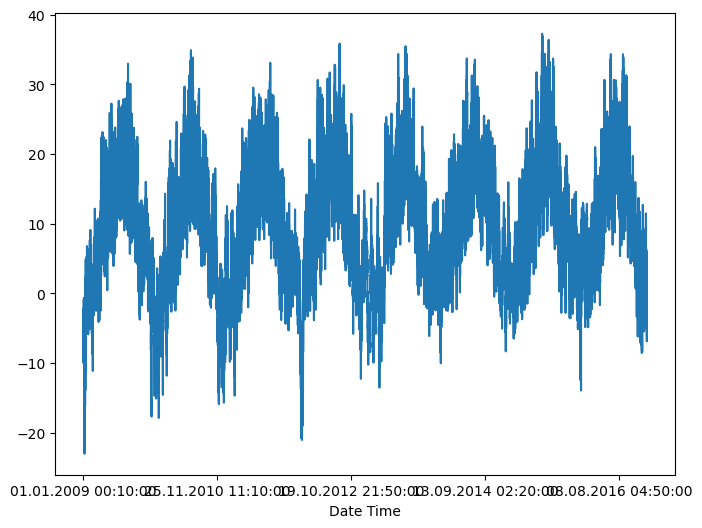

In [13]:
uni_data.plot(subplots=True)

In [14]:
oneD_uni_data=uni_data.values
oneD_uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a tf.keras.utils.normalize method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [15]:
uni_train_mean = oneD_uni_data[:TRAIN_SPLIT].mean()
uni_train_std = oneD_uni_data[:TRAIN_SPLIT].std()

In [16]:
#standardize the data using the calculated statistics
clean_oneD_uni_data = (oneD_uni_data - uni_train_mean)/uni_train_std
clean_oneD_uni_data

array([-1.9977, -2.0428, -2.0544, ..., -1.4349, -1.5588, -1.6272])

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [17]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(clean_oneD_uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(clean_oneD_uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


In [18]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.9977]
 [-2.0428]
 [-2.0544]
 [-2.0312]
 [-2.0266]
 [-2.0011]
 [-1.9513]
 [-1.9513]
 [-1.9849]
 [-2.0451]
 [-2.0833]
 [-2.0972]
 [-2.0938]
 [-2.0914]
 [-2.0718]
 [-2.0718]
 [-2.0764]
 [-2.0891]
 [-2.0926]
 [-2.1042]]

 Target temperature to predict
-2.1041848598100876


In [19]:
def create_time_steps(length):
  return list(range(-length, 0))

In [20]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\CompSci\\apps\\anaconda3\\envs\\machine_learning\\lib\\site-packages\\matplotlib\\pyplot.py'>

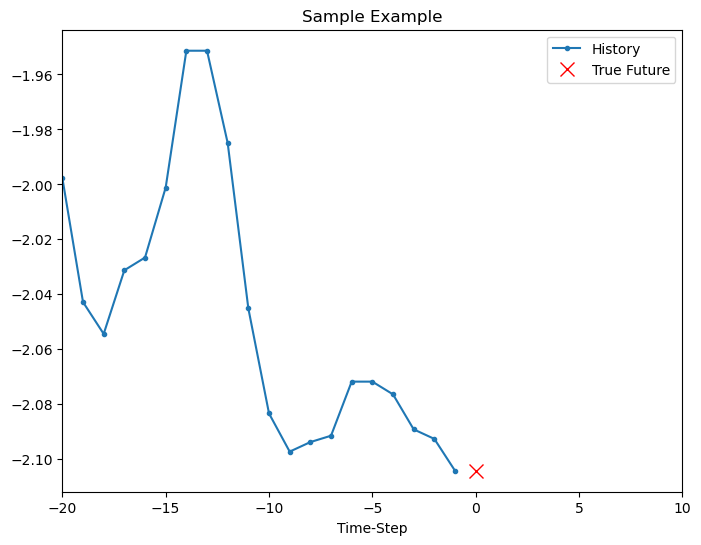

In [21]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [22]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\CompSci\\apps\\anaconda3\\envs\\machine_learning\\lib\\site-packages\\matplotlib\\pyplot.py'>

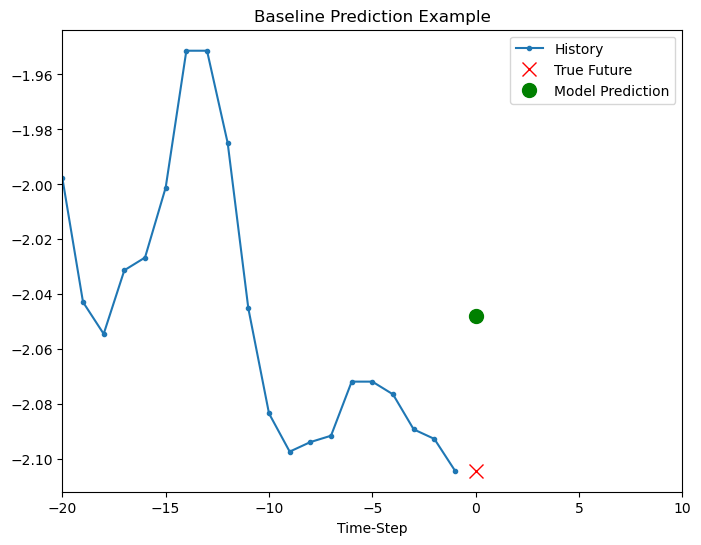

In [23]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the RNN tutorial. In this tutorial, you will use a specialized RNN layer called Long Short Term Memory (LSTM)

Let's now use tf.data to shuffle, batch, and cache the dataset.

In [24]:
#BATCH_SIZE = 256
BATCH_SIZE=256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Here is what the data looks like now that it has been batched.

![title](img/time_series.png)

In [26]:
#Note: https://stackoverflow.com/questions/58479556/notimplementederror-cannot-convert-a-symbolic-tensor-2nd-target0-to-a-numpy
# Ensure you're using Numpy 1.19 as 1.20+ has issues with Tensorflow < 2.6

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [27]:
#Let's make a sample prediction, to check the output of the model.

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)
   

(256, 1)


In [28]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)


Epoch 1/10
200/200 [==============================] - 4s 19ms/step - loss: 0.5303 - val_loss: 0.1293
Epoch 2/10
200/200 [==============================] - 4s 19ms/step - loss: 0.1019 - val_loss: 0.0320
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0423 - val_loss: 0.0260
Epoch 4/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0385 - val_loss: 0.0226
Epoch 5/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0256 - val_loss: 0.0212
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0281 - val_loss: 0.0201
Epoch 7/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0255 - val_loss: 0.0189
Epoch 8/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0181
Epoch 9/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0234 - val_loss: 0.0170
Epoch 10/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 

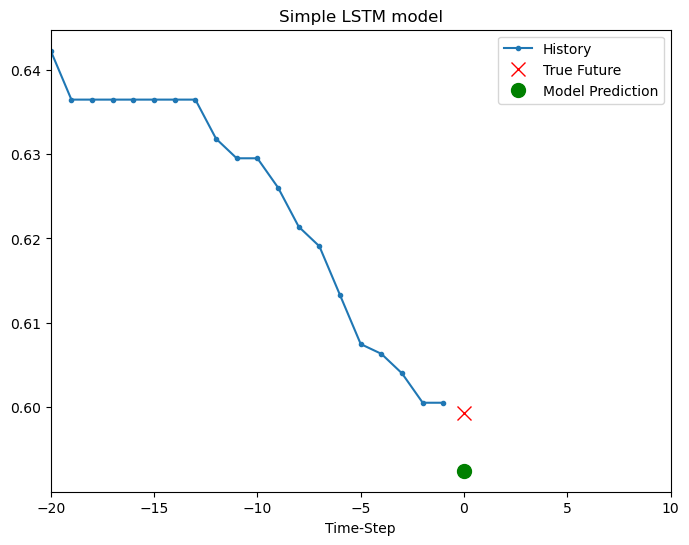

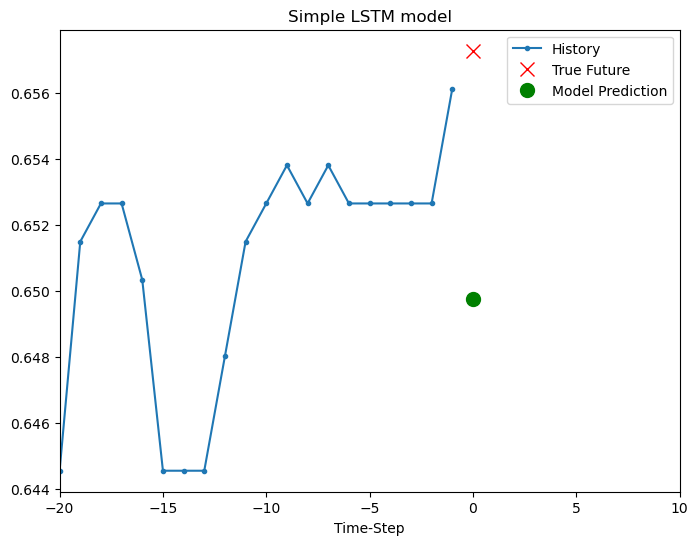

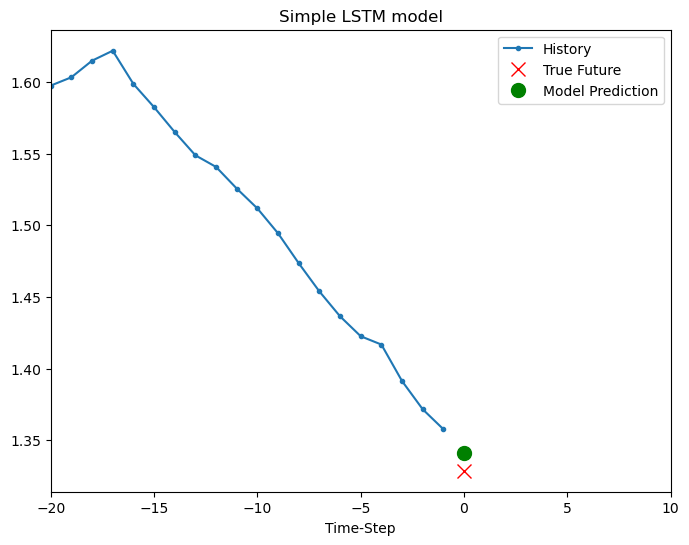

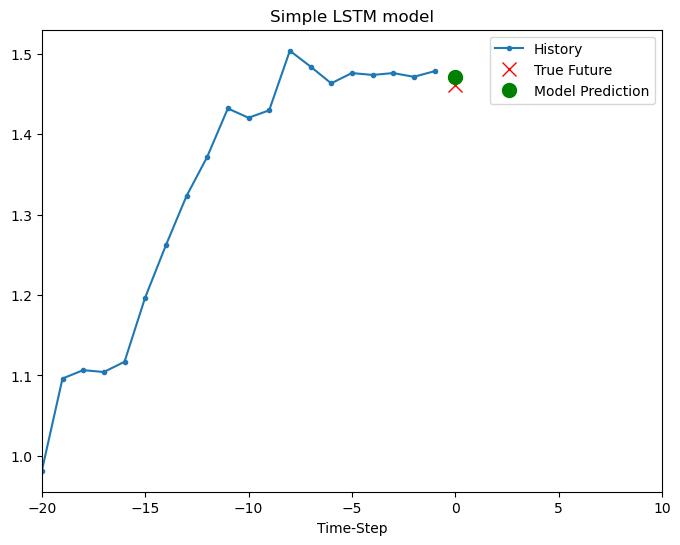

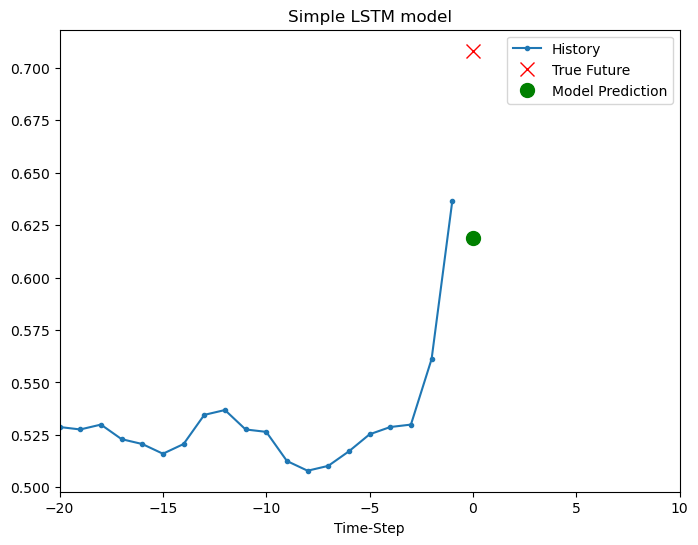

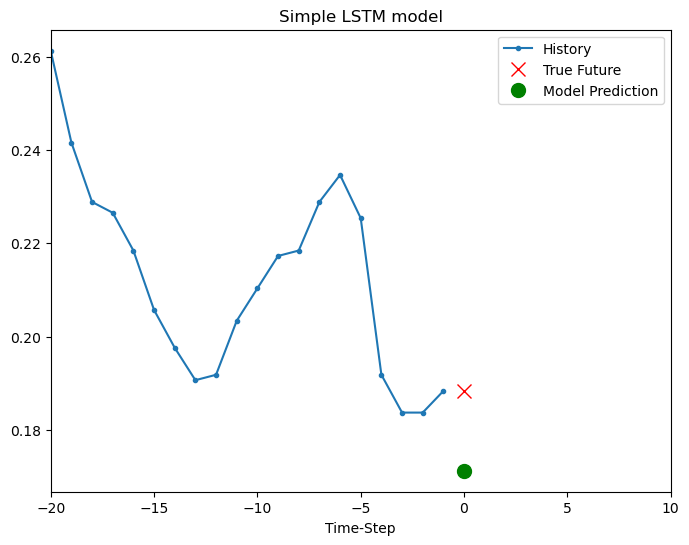

In [30]:
for x, y in val_univariate.take(6):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()